# Fine-Tuning Large Language Models for Enterprise Applications | DataBytes
## Use Case 2: Medical Misinformation Detection in LLM Responses
### Manusha Fernando | S223259359 |s223259359@deakin.edu.au

### Introduction

For this usecase, I fine-tuned Flan-T5 XL model to detect if given medical claims are True, False, or Misleading.

### Load Libraries and Dependencies



In [1]:
pip install datasets gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 137.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.7 MB/s eta 0:00:00


In [2]:
import os
import torch
import json
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from huggingface_hub import login
from google.colab import userdata
from peft import LoraConfig, get_peft_model, TaskType
import gradio as gr

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Log into Hugging Face



In [4]:
# Get token from Colab secret using userdata
# Replace "HF-key" with the exact name of your secret in Colab
hf_token = userdata.get('HF-key')

# Login to Hugging Face
login(token=hf_token, add_to_git_credential=True)

print("Hugging Face login successful")

Hugging Face login successful


### GPU Check



In [5]:
# Check if GPU is available
if torch.cuda.is_available():
    device = "cuda"
    print("GPU is available. Using CUDA.")
else:
    device = "cpu"
    print("GPU not available. Using CPU.")

GPU is available. Using CUDA.


### Load Tokenizer and Pretrained Model

This block initializes the `Flan-T5 XL` model and tokenizer using Hugging Face’s Transformers library.

In [6]:
model_id = "google/flan-t5-xl"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### Load Datasets




In [ ]:
with open("/content/drive/MyDrive/FTLLM/Datasets/scifact_train.jsonl", "r") as f:
    scifact_train = [json.loads(line) for line in f]

with open("/content/drive/MyDrive/FTLLM/Datasets/healthfact_train.json", "r") as f:
    healthfact_train = [json.loads(line) for line in f]

scifact_train_ds = Dataset.from_pandas(pd.DataFrame(scifact_train))
healthfact_train_ds = Dataset.from_pandas(pd.DataFrame(healthfact_train))

# Format functions
def format_scifact(dataset):
    inputs = [f"Claim: {ex['claim']}\nEvidence: {ex['evidence_text']}\nIs this claim true, false, or misleading?\nAnswer:" for ex in dataset]
    targets = [ex['label'] for ex in dataset]
    return Dataset.from_dict({"input": inputs, "target": targets})

def format_healthfact(dataset):
    inputs = [f"Claim: {ex['claim']}\nExplanation: {ex['explanation']}\nIs this claim true, false, or misleading?\nAnswer:" for ex in dataset]
    targets = [ex['label'] for ex in dataset]
    return Dataset.from_dict({"input": inputs, "target": targets})

### Tokenize Dataset

In [ ]:
def tokenize_dataset(dataset, tokenizer, max_input_len=512, max_target_len=128):
    def preprocess(example):
        model_input = tokenizer(example["input"], max_length=max_input_len, truncation=True, padding="max_length")
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(example["target"], max_length=max_target_len, truncation=True, padding="max_length")
        model_input["labels"] = labels["input_ids"]
        return model_input
    return dataset.map(preprocess, batched=True)

### Fine-Tune the model

In [ ]:
def fine_tune_model_custom(model, tokenizer, tokenized_data, output_dir="./results", epochs=3, lr=3e-5, batch_size=2):
    model.gradient_checkpointing_enable()
    args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        learning_rate=lr,
        weight_decay=0.01,
        eval_strategy="epoch",
        logging_dir=f"{output_dir}/logs",
        save_total_limit=1,
        fp16=torch.cuda.is_available(),
        report_to="none"
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_data,
        eval_dataset=tokenized_data,
        tokenizer=tokenizer,
        data_collator=DataCollatorForSeq2Seq(tokenizer, model=model)
    )
    trainer.train()
    return trainer

### Inference and Evaluation

In [ ]:
def generate_predictions(df, model, tokenizer, device="cuda"):
    predictions = []
    for prompt in df['input']:
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=100,
                temperature=0.7,
                top_p=0.9,
                top_k=50,
                repetition_penalty=1.1,
                do_sample=True
            )
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(prediction)
    df['prediction'] = predictions
    return df

def evaluate_predictions(df, title="Confusion Matrix"):
    true_labels = [label.lower().strip() for label in df['target']]
    pred_labels = [label.lower().strip() for label in df['prediction']]
    acc = accuracy_score(true_labels, pred_labels)
    print(f"Accuracy: {acc:.2%}")
    labels = ["true", "false", "misleading"]
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.grid(False)
    plt.show()
    return acc

### Benchmark Utility

In [ ]:
def run_scifact_benchmark(model, tokenizer, benchmark_path, title, output_file):
    with open(benchmark_path, "r") as f:
        data = [json.loads(line) for line in f]
    inputs = [
        f"Claim: {item['claim']}\nEvidence: {item['evidence_text']}\nIs this claim true, false, or misleading?\nAnswer:"
        for item in data
    ]
    targets = [item['label'] for item in data]
    df = pd.DataFrame({"input": inputs, "target": targets})
    result = generate_predictions(df, model, tokenizer, device)
    evaluate_predictions(result, title)
    result.to_csv(output_file, index=False)

def run_healthfact_benchmark(model, tokenizer, benchmark_path, title, output_file):
    # Changed from json.load to reading line by line, assuming JSON Lines format
    data = []
    with open(benchmark_path, "r") as f:
        for line in f:
            # Use json.loads to parse each line as a JSON object
            data.append(json.loads(line))

    inputs = [
        f"Claim: {item['claim']}\nExplanation: {item['explanation']}\nIs this claim true, false, or misleading?\nAnswer:"
        for item in data
    ]
    targets = [item['label'] for item in data]
    df = pd.DataFrame({"input": inputs, "target": targets})
    result = generate_predictions(df, model, tokenizer, device)
    evaluate_predictions(result, title)
    result.to_csv(output_file, index=False)

### Basic Prompt

This section sends a simple prompt to the Flan-T5 XL model for generation. The prompt asks whether garlic can cure high blood pressure. The input is tokenized and moved to the selected device (GPU), and the model generates a response using sampling-based decoding parameters: `temperature`, `top_k`, and `top_p`. The result is decoded and printed as a natural language answer.

In [ ]:
def generate_answer(prompt, model, tokenizer, device="cuda"):
    # Tokenize and prepare input
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)

    # Generate output
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            min_length=20,
            do_sample=True,
            temperature=0.5,
            top_k=50,
            top_p=0.9
        )

    # Decode and return result
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


# Example usage
test_prompt = "Can garlic cure high blood pressure?"
response = generate_answer(test_prompt, model, tokenizer, device)
print("Answer:", response)

Answer: Garlic is a spice that is high in antioxidants and has been shown to lower blood pressure


### Structured Prompt

This block performs a structured classification task using a prompt template. It presents a medical claim in a clear format and explicitly asks the model to classify it as true, false, or misleading. The input is tokenized and passed to the model, which generates an answer with controlled sampling parameters. The output is then decoded and printed as the model's classification of the claim.


In [ ]:
def classify_claim(claim, model, tokenizer, device="cuda"):
    # Build structured prompt
    prompt = (
        f"Claim: {claim}\n"
        "Is this claim true, false, or misleading?\n"
        "Answer:"
    )

    # Tokenize and move to device
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)

    # Generate output
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            temperature=0.7,
            top_p=0.9,
            top_k=50,
            repetition_penalty=1.1,
            do_sample=True
        )

    # Decode and return response
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


# Example use
test_claim = "Garlic can cure high blood pressure."
result = classify_claim(test_claim, model, tokenizer, device)
print("Answer:", result)

Answer: false


### Base model (M1)



Accuracy: 79.00%


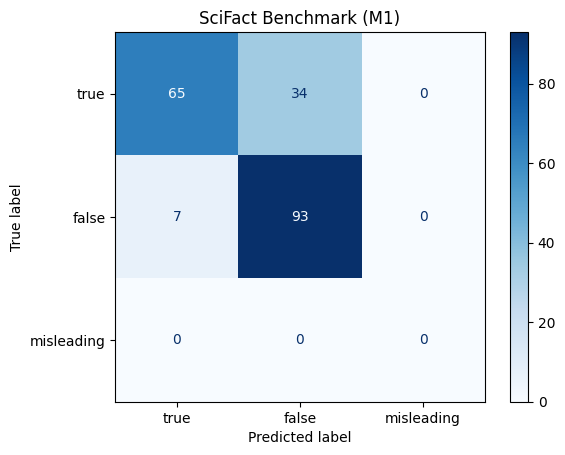

Accuracy: 68.00%


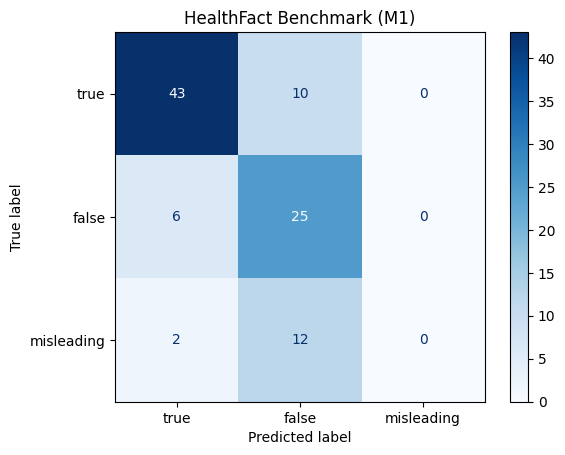

In [ ]:
run_scifact_benchmark(model, tokenizer, "/content/drive/MyDrive/FTLLM/Datasets/scifact_benchmark.jsonl", "SciFact Benchmark (M1)", "results_scifact_M1.csv")
run_healthfact_benchmark(model, tokenizer, "/content/drive/MyDrive/FTLLM/Datasets/healthfact_benchmark.json", "HealthFact Benchmark (M1)", "results_healthfact_M1.csv")

### Fine-tune model with 300 samples from SciFact (M2)



Map:   0%|          | 0/300 [00:00<?, ? examples/s]

<ipython-input-22-1ed68baacb50>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
1,No log,nan
2,No log,nan
3,No log,nan


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Accuracy: 77.00%


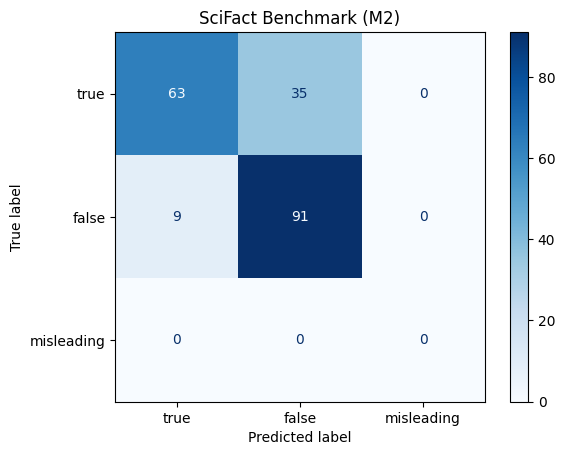

In [ ]:
scifact_subset = scifact_train_ds.select(range(300))
scifact_formatted = format_scifact(scifact_subset)
tokenized_scifact = tokenize_dataset(scifact_formatted, tokenizer)
fine_tune_model_custom(model, tokenizer, tokenized_scifact, output_dir="./results_M2")
run_scifact_benchmark(model, tokenizer, "/content/drive/MyDrive/FTLLM/Datasets/scifact_benchmark.jsonl", "SciFact Benchmark (M2)", "results_scifact_M2.csv")

### Hyperparameter tuning for M2 (M3)



<ipython-input-22-1ed68baacb50>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,nan
2,No log,nan
3,No log,nan
4,No log,nan


Accuracy: 77.50%


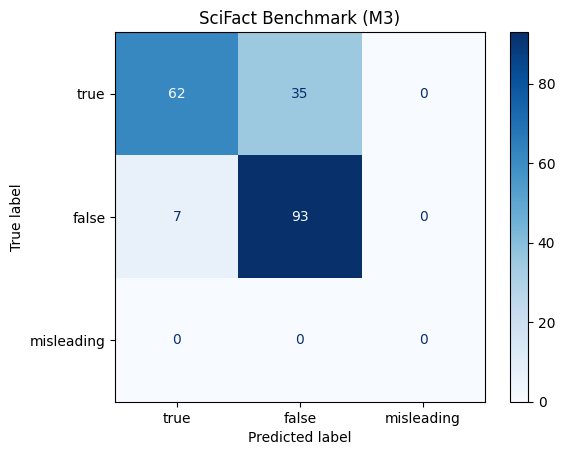

In [ ]:
fine_tune_model_custom(model, tokenizer, tokenized_scifact, output_dir="./results_M3", epochs=4, lr=5e-5, batch_size=4)
run_scifact_benchmark(model, tokenizer, "/content/drive/MyDrive/FTLLM/Datasets/scifact_benchmark.jsonl", "SciFact Benchmark (M3)", "results_scifact_M3.csv")

### Fine-tune M3 with 300 samples from HealthFact (M4)



Map:   0%|          | 0/300 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
<ipython-input-22-1ed68baacb50>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,nan
2,No log,nan
3,No log,nan


Accuracy: 64.00%


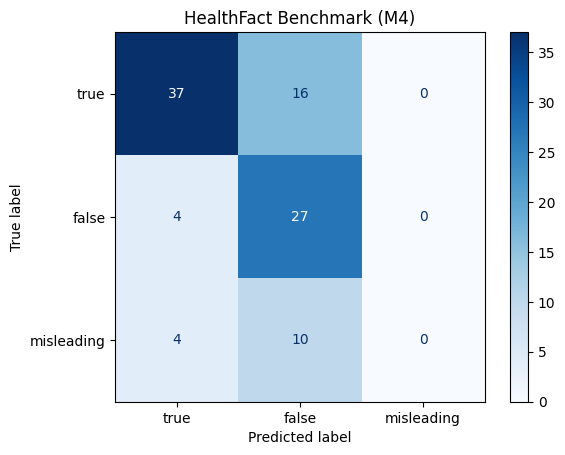

In [ ]:
healthfact_subset = healthfact_train_ds.select(range(300))
healthfact_formatted = format_healthfact(healthfact_subset)
tokenized_healthfact = tokenize_dataset(healthfact_formatted, tokenizer)
fine_tune_model_custom(model, tokenizer, tokenized_healthfact, output_dir="./results_M4")
run_healthfact_benchmark(model, tokenizer, "/content/drive/MyDrive/FTLLM/Datasets/healthfact_benchmark.json", "HealthFact Benchmark (M4)", "results_healthfact_M4.csv")

### Hyperparamater tuning for M4 (M5)



<ipython-input-22-1ed68baacb50>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,nan
2,No log,nan
3,No log,nan
4,0.000000,nan
5,0.000000,nan


Accuracy: 69.00%


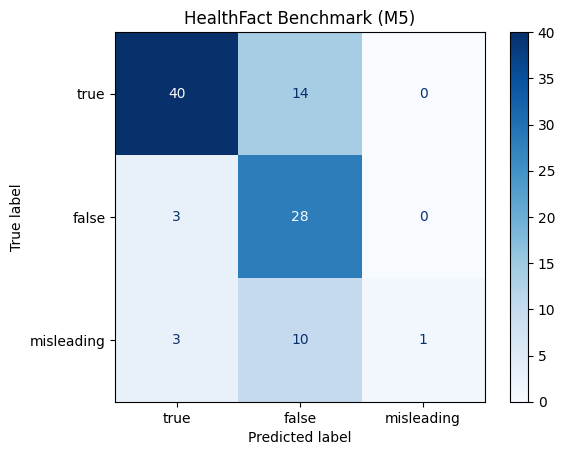

In [ ]:
fine_tune_model_custom(model, tokenizer, tokenized_healthfact, output_dir="./results_M5", epochs=5, lr=3e-5, batch_size=2)
run_healthfact_benchmark(model, tokenizer, "/content/drive/MyDrive/FTLLM/Datasets/healthfact_benchmark.json", "HealthFact Benchmark (M5)", "results_healthfact_M5.csv")

### Fine-Tuning M5 with LoRA

<ipython-input-22-1ed68baacb50>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 4,718,592 || all params: 2,854,475,776 || trainable%: 0.1653


Epoch,Training Loss,Validation Loss
1,No log,nan
2,No log,nan
3,No log,nan


Accuracy: 69.00%


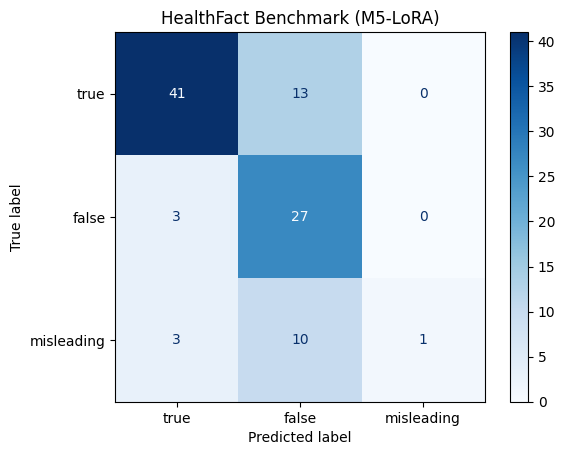

In [ ]:
# Load M5 model from directory (if saved) or use in-memory model
# model = AutoModelForSeq2SeqLM.from_pretrained("./model_M5").to(device)
# If already in memory from M5, skip above line

# LoRA configuration
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q", "v"],  # or ["q_proj", "v_proj"] depending on model internals
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

# Wrap with PEFT LoRA
model_lora = get_peft_model(model, lora_config)
model_lora.print_trainable_parameters()  # Only LoRA params should be trainable

m5_lora_trainer = fine_tune_model_custom(
    model=model_lora,
    tokenizer=tokenizer,
    tokenized_data=tokenized_healthfact,
    output_dir="./results_M5_LoRA",
    epochs=3,
    lr=1e-4,           # Typically a bit higher than full FT
    batch_size=2
)

run_healthfact_benchmark(
    model=model_lora,
    tokenizer=tokenizer,
    benchmark_path="/content/drive/MyDrive/FTLLM/Datasets/healthfact_benchmark.json",
    title="HealthFact Benchmark (M5-LoRA)",
    output_file="results_healthfact_M5_LoRA.csv"
)

### Comparison



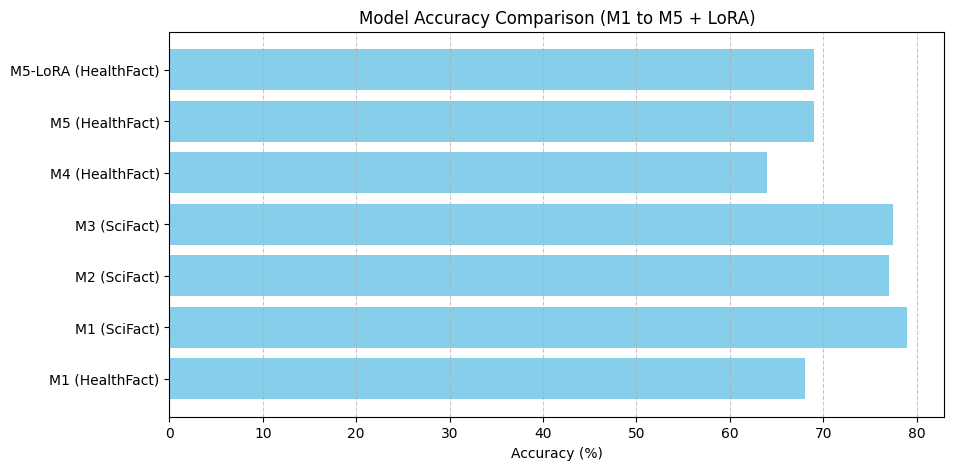

,Model,Accuracy
3,M1 (HealthFact),68.0
0,M1 (SciFact),79.0
1,M2 (SciFact),77.0
2,M3 (SciFact),77.5
4,M4 (HealthFact),64.0
5,M5 (HealthFact),69.0
6,M5-LoRA (HealthFact),69.0


In [ ]:
def compute_accuracy_from_csv(path):
    df = pd.read_csv(path)
    # Explicitly convert the 'target' column to string type before processing
    df["target"] = df["target"].astype(str)
    true_labels = [x.lower().strip() for x in df["target"]]
    # Explicitly convert the 'prediction' column to string type before processing
    df["prediction"] = df["prediction"].astype(str)
    pred_labels = [x.lower().strip() for x in df["prediction"]]
    return accuracy_score(true_labels, pred_labels)

results = {
    "M1 (SciFact)": compute_accuracy_from_csv("results_scifact_M1.csv"),
    "M2 (SciFact)": compute_accuracy_from_csv("results_scifact_M2.csv"),
    "M3 (SciFact)": compute_accuracy_from_csv("results_scifact_M3.csv"),
    "M1 (HealthFact)": compute_accuracy_from_csv("results_healthfact_M1.csv"),
    "M4 (HealthFact)": compute_accuracy_from_csv("results_healthfact_M4.csv"),
    "M5 (HealthFact)": compute_accuracy_from_csv("results_healthfact_M5.csv"),
    "M5-LoRA (HealthFact)": compute_accuracy_from_csv("results_healthfact_M5_LoRA.csv")
}

# Show as DataFrame
summary_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
summary_df["Accuracy"] = (summary_df["Accuracy"] * 100).round(2)
summary_df.sort_values("Model", inplace=True)

# Bar plot
plt.figure(figsize=(10, 5))
plt.barh(summary_df["Model"], summary_df["Accuracy"], color="skyblue")
plt.xlabel("Accuracy (%)")
plt.title("Model Accuracy Comparison (M1 to M5 + LoRA)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

summary_df

The accuracy results from the fine-tuning and benchmarking reveal some important insights about model performance across the SciFact and HealthFact datasets.

On the **SciFact dataset**, the base model (M1) achieved the highest accuracy at 79%, outperforming both M2 (77%) and M3 (77.5%). This suggests that the pre-trained Flan-T5 XL model already generalizes well to scientific fact-checking tasks without the need for additional tuning. The marginal decline in performance after fine-tuning on 300 samples (M2 and M3) could be due to the small dataset size, overfitting, or misalignment between the fine-tuning data distribution and the model’s pre-trained knowledge. Essentially, in this case, fine-tuning did not offer a substantial benefit, and the base model retained the upper hand.

For the **HealthFact dataset**, the base model (M1) also started strong with 68% accuracy. However, the initial fine-tuning in M4 led to a drop in performance to 64%, which may indicate early-stage underfitting or the introduction of noise from a limited fine-tuning dataset. Interestingly, further fine-tuning in M5 improved the performance to 69%, showing that iterative tuning helped the model adapt better to the domain. Notably, the LoRA-based variant (M5-LoRA) achieved the same 69% accuracy as M5, but with significantly less computational overhead and no need to update the full model weights.

Overall, these results demonstrate that while full fine-tuning can improve performance in certain cases (as seen with HealthFact), pre-trained models like Flan-T5 XL are often highly capable out of the box, particularly on well-aligned datasets like SciFact. Additionally, the use of LoRA is validated as an effective and efficient alternative to traditional fine-tuning, achieving the same level of accuracy as M5 while being more resource-friendly.

### UI Integration



In [ ]:
# Prediction function for HealthFact-style input
def classify_ui(claim, explanation):
    prompt = (
        f"Claim: {claim}\n"
        f"Explanation: {explanation}\n"
        "Is this claim true, false, or misleading?\nAnswer:"
    )

    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        outputs = model_lora.generate(
            **inputs,
            max_new_tokens=100,
            temperature=0.7,
            top_p=0.9,
            top_k=50,
            repetition_penalty=1.1,
            do_sample=True
        )

    output_text = tokenizer.decode(outputs[0], skip_special_tokens=True).lower()

    # Extract the first label keyword
    for label in ["true", "false", "misleading"]:
        if label in output_text:
            return label.capitalize()

    return "Uncertain"


# Gradio UI
gr.Interface(
    fn=classify_ui,
    inputs=[
        gr.Textbox(label="Enter Medical Claim"),
        gr.Textbox(label="Enter Explanation / Context")
    ],
    outputs=gr.Textbox(label="Classification (True / False / Misleading)"),
    title="Medical Misinformation Classifier (LLM + LoRA)",
    description="Provide a medical claim and an optional explanation. The fine-tuned model (M5-LoRA) will classify it as True, False, or Misleading."
).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b760c835c6aae11487.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Conclusion

